In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
d = pd.read_csv('clean_candy.csv')
d.head()

,Timestamp,PA,PB,FLP,FLT,WTP,V
0,2018-01-01 00:00:00,2070.508057,1326.526569,648.307800,41.032509,1271.876099,8538.653320
1,2018-01-01 00:01:00,2070.637695,1326.473592,667.404175,41.602646,1271.616821,8496.515625
2,2018-01-01 00:02:00,2070.637695,1326.420614,667.404175,41.602646,1271.616821,8496.515625
3,2018-01-01 00:03:00,2070.637695,1326.367636,667.404175,41.602646,1271.616821,8496.515625
4,2018-01-01 00:04:00,2070.637695,1326.314659,667.404175,41.602646,1271.616821,8496.515625


In [11]:
print('Number of rows and columns:', d.shape)
print('The time series starts from: ', d.Timestamp.min())
print('The time series ends on: ', d.Timestamp.max())

Number of rows and columns: (218865, 7)
The time series starts from:  2018-01-01 00:00:00
The time series ends on:  2018-06-13 05:00:00


## Focus on Volume - Production variable

In [18]:
df1=d.loc[:,['Timestamp','V']]
df1.set_index('Timestamp', inplace=True)

In [19]:
from scipy import stats
stat, p = stats.normaltest(df1.V)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=16602.044, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 0.2679207463923565
Skewness of normal distribution: 0.7398122641009348


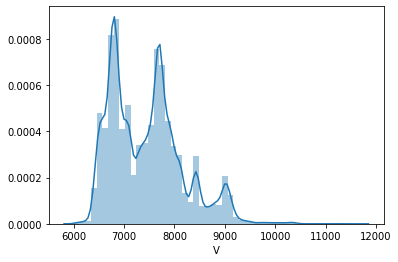

In [20]:
sns.distplot(df1.V);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(d.V)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(d.V)))

Kurtosis: describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0.And our Kurtosis is greater than zero, so Volume variable distribution has heavier tails.

Skewness: measures asymmetry of the distribution
If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. 

,count,mean,std,min,25%,50%,75%,max
V,218865.0,7444.863531,714.86032,6001.489746,6822.369141,7410.152832,7850.719727,11657.337891


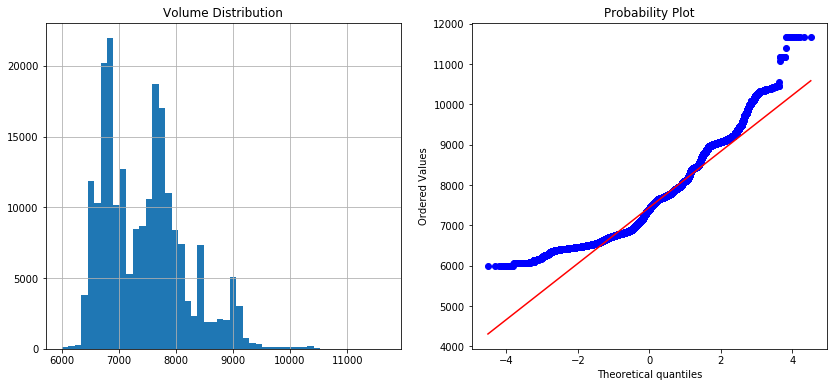

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df1['V'].hist(bins=50)
plt.title('Volume Distribution')
plt.subplot(1,2,2)
stats.probplot(df1['V'], plot=plt);
df1.describe().T

## Data Pre-processing

1) Create the dataset, ensure all data is float.

2) Normalize the features.

3) Split into training and test sets.

4) Convert an array of values into a dataset matrix.

5) Reshape into X=t and Y=t+1.

6) Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [61]:
#create dataset
dataset = df1.V.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [62]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [63]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [64]:
#reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(175061, 1, 30) (175061,) (43742, 1, 30) (43742,)


## Model

1. LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Volume. 
2. The input shape will be 1 time step.
3. Dropout 20%. Dropout layer is added to avoid over-fitting(ML model performs better on the train compared to test. 
4. Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
5. The model will be fit for 20 training epochs with a batch size of 70.

In [65]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 175061 samples, validate on 43742 samples
Epoch 1/20
175061/175061 [==============================] - 8s 43us/step - loss: 7.9151e-04 - accuracy: 7.9972e-05 - val_loss: 4.2541e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
175061/175061 [==============================] - 7s 41us/step - loss: 4.6034e-04 - accuracy: 7.9972e-05 - val_loss: 4.4958e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
175061/175061 [==============================] - 7s 43us/step - loss: 5.7257e-04 - accuracy: 7.9972e-05 - val_loss: 1.9425e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
175061/175061 [==============================] - 8s 44us/step - loss: 4.4226e-04 - accuracy: 7.9972e-05 - val_loss: 8.8565e-05 - val_accuracy: 0.0000e+00
Epoch 5/20
175061/175061 [==============================] - 8s 44us/step - loss: 3.4708e-04 - accuracy: 7.9972e-05 - val_loss: 4.6610e-05 - val_accuracy: 0.0000e+00
Epoch 6/20
175061/175061 [==============================] - 8s 45us/step - loss: 3.1664e-04 - accuracy: 7.9972e-05 - val_los

## Prediction

In [70]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
#invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 92.55820922342957
Train Root Mean Squared Error: 153.07537634796995
Test Mean Absolute Error: 17.71482967992603
Test Root Mean Squared Error: 27.68167096065893


## Plot Model Loss

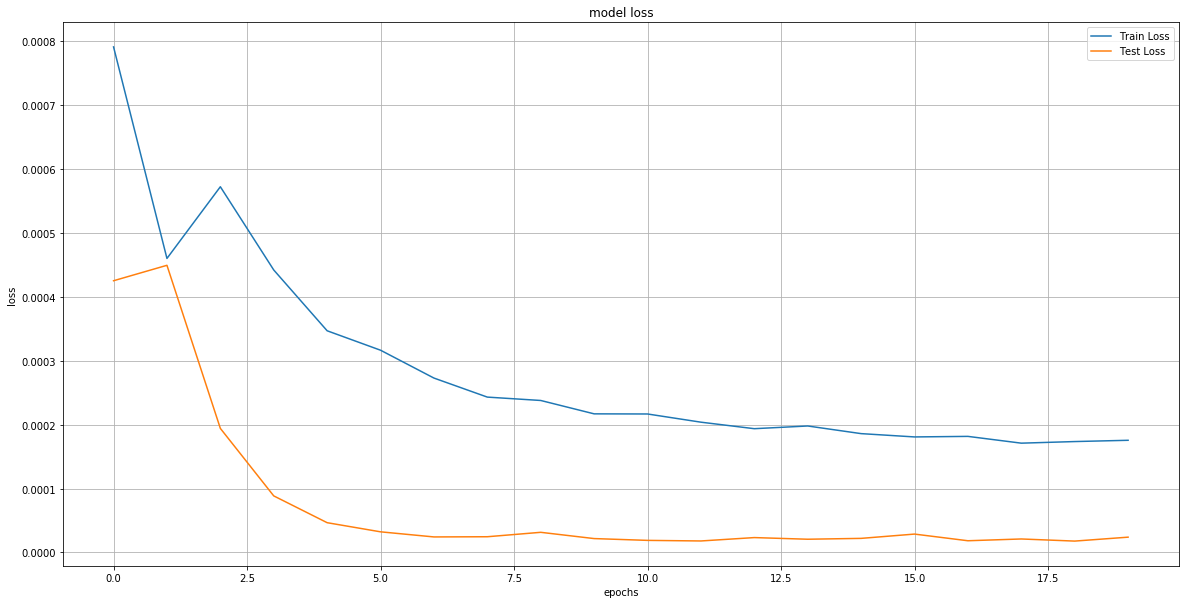

In [71]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

## Actual vs Prediction for the last 200 minutes

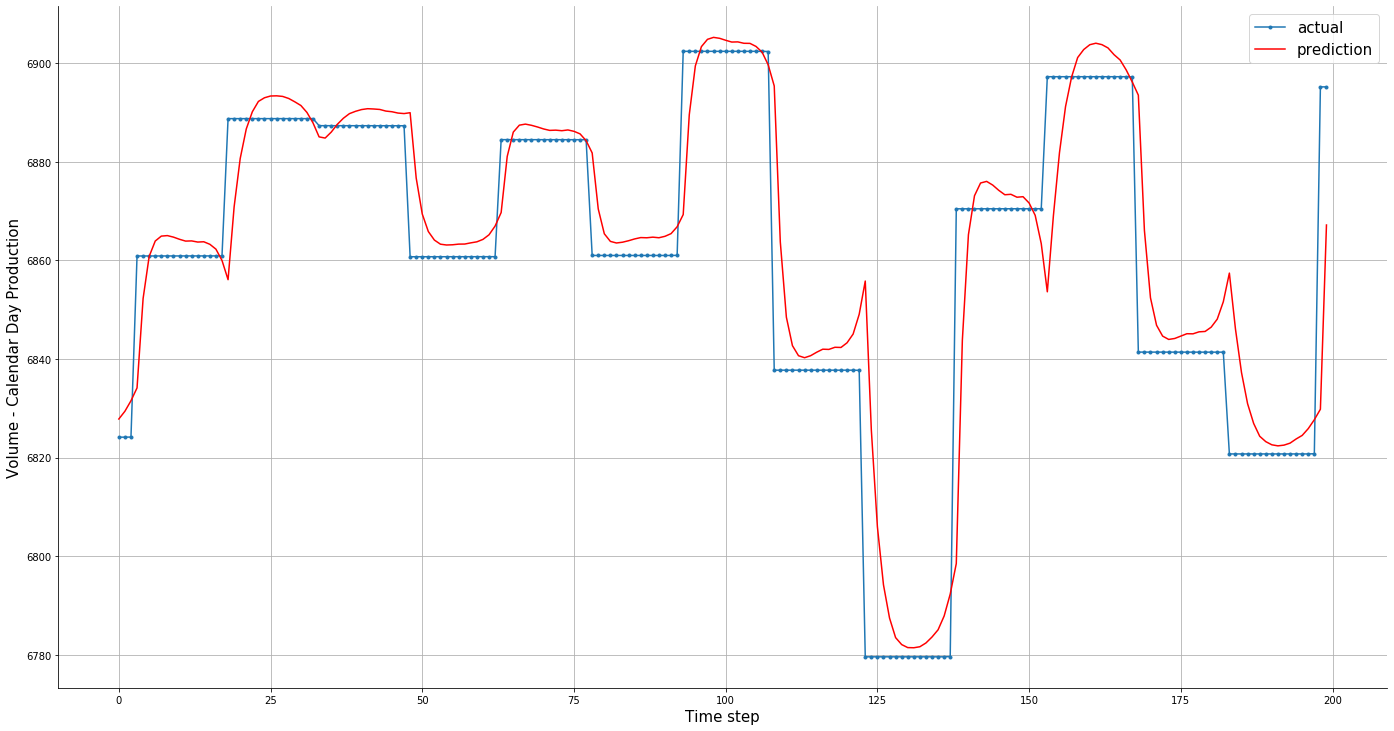

In [72]:
a=[x for x in range(200)]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(a, Y_test[0][:200], marker='.', label="actual")
plt.plot(a, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Volume - Calendar Day Production', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()